<a href="https://colab.research.google.com/github/Paloschi/Arduino/blob/master/AGRIRISK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mapeamento de cultivares agrícolas**

# **Identificação e login no google drive e Engine**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=_QDoOQYQq0ATYmDNGP5XdlgkMWON_9Og4jQ7txXHmSo&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AfDhmrhrvpPmVKQrUAbjZ1wsj-wZj9Dr7NQ3QB4Y857AKOXwz5IiRxeSUTc

Successfully saved authorization token.


# **Instalação de Bibliotecas**

In [ ]:
pip install geopandas

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 14.8MB 311kB/s 
     |████████████████████████████████| 6.5MB 32.4MB/s 


#**Importação de bibliotecas**

In [ ]:
import ee
import folium
from folium import plugins
from IPython.display import Image
from osgeo import gdal 
from osgeo import gdal_array
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

#**Seleção da área de interesse**

In [ ]:
shapefile = gpd.read_file('/content/drive/My Drive/Agririsk/3 - Análises/PR_Mesorregioes_2019/PR_Mesorregioes_2019.shp')

In [ ]:
shapefile.head()

,CD_MESO,NM_MESO,SIGLA_UF,geometry
0,4101,Noroeste Paranaense,PR,"POLYGON ((-53.71491 -23.28338, -53.71285 -23.2..."
1,4102,Centro Ocidental Paranaense,PR,"POLYGON ((-53.13159 -24.10287, -53.12476 -24.0..."
2,4103,Norte Central Paranaense,PR,"POLYGON ((-52.03689 -23.02207, -52.03268 -23.0..."
3,4104,Norte Pioneiro Paranaense,PR,"POLYGON ((-50.96340 -23.30342, -50.96258 -23.3..."
4,4105,Centro Oriental Paranaense,PR,"POLYGON ((-51.09801 -24.32583, -51.09618 -24.3..."


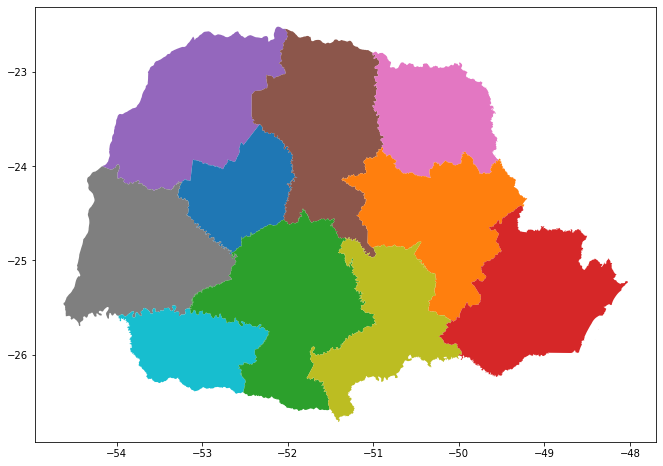

In [ ]:
shapefile.plot(column='NM_MESO', figsize=(16,8))

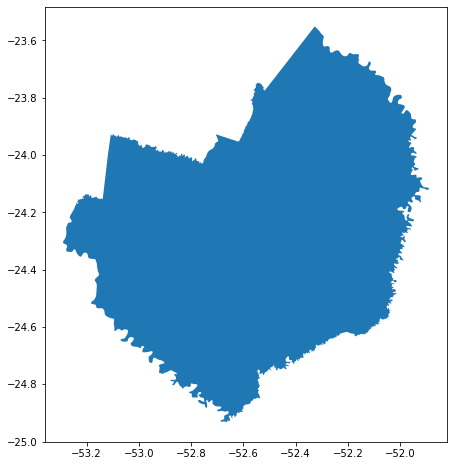

In [ ]:
pr_meso = shapefile[shapefile.CD_MESO == "4102"]
pr_meso.plot(column='NM_MESO', figsize=(16,8))

# **Baixar Imagens**


In [ ]:
raster_soja = "/content/drive/My Drive/Agririsk/3 - Análises/spam2010v1r0_global_harvested-area_maiz_h.tif"

In [ ]:
raster_soja = gdal.Open(raster_soja)

In [ ]:
type(raster)

osgeo.gdal.Dataset

In [ ]:
# Projeção
print(raster.GetProjection())
print(" ")

# Dimensões
print(raster.RasterXSize)
print(raster.RasterYSize)
print(" ")

# Numero de bandas
print(raster.RasterCount)
print(" ")

# Metadados do arquivo raster
print(raster.GetMetadata())
print(" ")

In [ ]:
#Lendo como uma matriz numerica
data = raster.ReadAsArray() 

#Isso servirá para definir as lats e lons
x0, dx, dxdy, y0, dydx, dy = raster.GetGeoTransform() 

#Obtendo o numero de linhas e colunas da matriz
nrows, ncols = data.shape  

In [ ]:
# Gerando arrays para longitude e latitude
londata = np.linspace(x0, x0+dx*ncols, ncols)
latdata = np.linspace(y0, y0+dy*nrows, nrows)

lon, lat = np.meshgrid(londata, latdata) # Fazendo um grid de lat e lon paraos dados de elevação

print(latdata.shape, londata.shape) 

(2160,) (4320,)


In [ ]:
fig = plt.figure(figsize=(9, 9)) 
fig = subplots(2,2)
plt.plot(raster_soja )
plt.show

NameError: ignored

<Figure size 648x648 with 0 Axes>

In [ ]:
imageCollection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") # Series Landsat

# **Tratamento das Imagens**

In [ ]:
# Seleciona apenas as imagens que sobrepõe o Centro Ocidental
imageCollection = imageCollection.filterBounds(roi)

In [ ]:
filtered_L8 = imageCollection.map(maskS2clouds);



In [ ]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 1000,
}

# Create a folium map object.
my_map = folium.Map(location=[-30, -45], zoom_start=5, height=500)

# Add the image to the map object.
my_map.add_ee_layer(imageCollection.first, None, 'L8')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)


#**Funções de apoio**

In [ ]:
def maskS2clouds(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 8 SR data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 8 SR image
  
  Return:
  -------
  cloudmasked Landsat 8 image
  '''
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = img.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)\
           .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  return img.updateMask(mask)  

In [ ]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# **Classificação Redes Neurais**